In [1]:
# Import libraries
import sys
sys.path.append('../')
import numpy as np 
import pandas as pd 
import os
import warnings
import torch
from torchvision import datasets, transforms, models
from torchvision.models import vgg11
from torch.autograd import Variable
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from sklearn.exceptions import ConvergenceWarning
import sklearn.linear_model as slm
import sklearn.feature_selection as skf
import sklearn.model_selection as sms
import sklearn.preprocessing as skp
import util
from adapt.feature_based import CORAL
import cv2

In [2]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528_wldd.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','pre op levadopa equivalent dose (mg)','CORNELL ID')
# Find cases with all required scores
subs_init,pre_imp_init,post_imp_init,pre_updrs_off_init,ledd_init = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo',
                                                          'pre op levadopa equivalent dose (mg)')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
del Phi_all, X_all, R_all, K_all
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs_init).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs_init,ids[c_cases_idx])
subs_init = subs_init[s_cases_idx]
pre_imp_init = pre_imp_init[s_cases_idx]
post_imp_init = post_imp_init[s_cases_idx]
pre_updrs_off_init = pre_updrs_off_init[s_cases_idx]
ledd_init = ledd_init[s_cases_idx]
per_change_init = post_imp_init
subs = np.asarray(ID_all,dtype=float)[np.in1d(np.asarray(ID_all,dtype=float),subs_init)]

pre_imp = np.zeros((1,len(subs))).T
post_imp = np.zeros((1,len(subs))).T
pre_updrs_off = np.zeros((1,len(subs))).T
per_change = np.zeros((1,len(subs))).T
ledd = np.zeros((1,len(subs))).T
for j in np.arange(len(subs)):
    pre_imp[j] = pre_imp_init[subs_init == subs[j]]
    post_imp[j] = post_imp_init[subs_init == subs[j]]
    pre_updrs_off[j] = pre_updrs_off_init[subs_init == subs[j]]
    per_change[j] = per_change_init[subs_init == subs[j]]
    ledd[j] = ledd_init[subs_init == subs[j]]

subsc = subs_init
X_img = []
results_bls = np.zeros_like(per_change)

       Unnamed: 0                PRE-OP           Unnamed: 2  \
0      CORNELL ID  Apathy Off (pre-dbs)  Apathy ON (pre-dbs)   
1              67                    na                   13   
2   only Ct data                     na                   na   
3              74                    na                   na   
4              84                    na                   22   
..            ...                   ...                  ...   
87             52                   NaN                  NaN   
88             53                   NaN                  NaN   
89             54                   NaN                  NaN   
90             55                   NaN                  NaN   
91             56                   NaN                  NaN   

             Unnamed: 3          Unnamed: 4    Unnamed: 5  \
0   OFF (pre-dbs updrs)  ON (pre-dbs updrs)  mri (pre-op)   
1                    60                  41      3/9/2020   
2                    43                  12     

In [3]:
pt_model = vgg11(weights='DEFAULT')
pt_model.classifier[0]
for param in pt_model.parameters():
    param.required_grad = False

In [4]:
pt_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
X_img, subsc0, per_change0, pre_metric0, pre_imp0 = util.slice_pick(subsc=subs_init,
                        per_change=per_change,
                        pre_metric=pre_updrs_off,
                        pre_comp=pre_imp,
                        pshape=(64,64,64),
                        roi_l=0,roi_u=4,
                        mask_crop_output=False,mask_output=False,o_index=False,
                        file_path='/home/ali/RadDBS-QSM/data/pt/X_img.pt',
                        qsm_path='/home/ali/RadDBS-QSM/data/nii/qsm',
                        seg_prefix='/home/ali/RadDBS-QSM/data/nii/seg/labels_2iMag0',
                        save_image=False,
                        img_directory='/home/ali/RadDBS-QSM/data/tif/',
                        visualize=False,
                        reload=False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

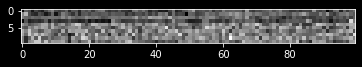

In [19]:
Z = []
zc = []
x = []
for j in np.arange(len(X_img)):
    x_img = X_img[j]
    x_img[x_img>250] = 250
    x_img[x_img<-250] = -250
    x.append(x_img.cpu().numpy())
    Z.append(util.get_latent_rep(X_img[j],pt_model).detach().numpy())
    zc.append(util.get_layer_output(X_img[j],pt_model,{"classifier.0": "layer4"})['layer4'].detach().numpy())
    plt.imshow(Z[j].reshape((10,100)),cmap="gray")

In [7]:
X = np.asarray(x)
# Zc = np.asarray(zc)

(-0.5, 575.5, 319.5, -0.5)

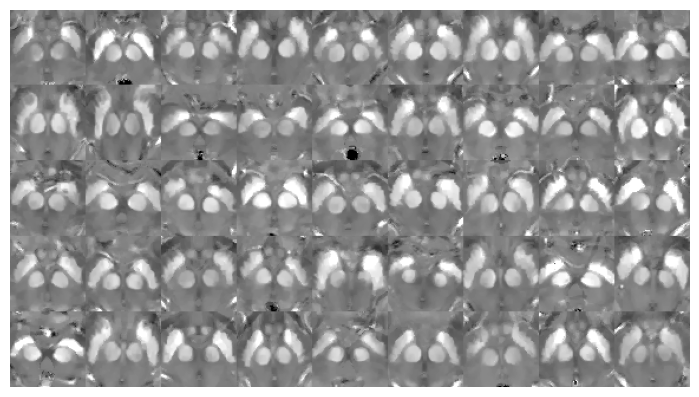

In [8]:
plt.figure(figsize=(9, 5), dpi=100)

plt.imshow(np.rot90(np.hstack((X[0:9,:].reshape((-1,64)),X[9:18,:].reshape((-1,64)),
                      X[18:27,:].reshape((-1,64)),X[27:36,:].reshape((-1,64)),
                     X[36:45,:].reshape((-1,64))))),cmap='gray')
                     
plt.style.use('dark_background')
plt.axis('off')


In [23]:
Z = np.asarray(Z)

(-0.5, 999.5, 44.5, -0.5)

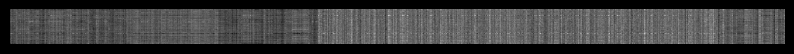

In [24]:
plt.figure(figsize=(10, 10), dpi=100)

plt.imshow(np.squeeze(Z.reshape(45,-1)),cmap="gray")
                     
plt.style.use('dark_background')
plt.axis('off')


In [25]:
# plt.imshow(np.squeeze(Zc1[0])[0,:,:])

In [26]:
# for j in np.arange(Zc1.shape[2]):
#     plt.figure(figsize=(9, 5), dpi=100)
#     c = j
#     plt.imshow(np.rot90(np.hstack((Zc1[0:9,0,c,:,:].reshape(-1,6),Zc1[9:18,0,c,:,:].reshape(-1,6),
#                         Zc1[18:27,0,c,:,:].reshape(-1,6),Zc1[27:36,0,c,:,:].reshape(-1,6),
#                         Zc1[36:45,0,c,:,:].reshape(-1,6)))),cmap='gray')
#     plt.imsave("./channels/fig"+str(j)+".jpeg",(np.rot90(np.hstack((Zc1[0:9,0,c,:,:].reshape(-1,6),Zc1[9:18,0,c,:,:].reshape(-1,6),
#                         Zc1[18:27,0,c,:,:].reshape(-1,6),Zc1[27:36,0,c,:,:].reshape(-1,6),
#                         Zc1[36:45,0,c,:,:].reshape(-1,6))))),cmap='gray')
                        
#     plt.style.use('dark_background')
#     plt.axis('off')



In [27]:
rerecord = 0
if rerecord == 1:
    image_folder = 'channels'
    video_name = 'channels.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".jpeg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [39]:
r = np.zeros(len(per_change))
err_var = np.zeros(len(per_change))
rerror = np.zeros(len(per_change))
kappa = []
results_ls = np.zeros(len(per_change))
scaler = skp.StandardScaler()
Z = np.asarray(Z.reshape(Z.shape[0],-1))
# Z = scaler.fit_transform(np.squeeze(Z))
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = Z[train_index]
    X_test = Z[test_index]
    y_train = per_change[train_index].ravel()
    y_test = per_change[test_index]

    X0_ss0 = X_train.reshape(X_train.shape[0],-1)
    X_test_ss0 = X_test.reshape(X_test.shape[0],-1)
    # Cross validation
    cvn = 5

    y_cat = y_train > 0.3
    # X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
    #                   
    #                           X_train,train_index,X_test,test_index,pre_metric,ledd,False,False,False)
    skf_gen = sms.StratifiedKFold(cvn).split(X0_ss0, y_cat)
    lasso = slm.LassoCV(cv=skf_gen)

    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.SelectKBest(skf.r_regression,k=100)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss)
      
    print('Lasso predicts',str(np.round(results_ls[j],2)),
              'for case with',str(np.round(per_change[j],2)))
              #'with regularization',str(est_ls.alpha_))

Lasso predicts 0.5 for case with [0.83]
Lasso predicts 0.61 for case with [0.91]
Lasso predicts 0.64 for case with [0.56]
Lasso predicts 0.61 for case with [0.95]
Lasso predicts 0.61 for case with [0.89]
Lasso predicts 0.62 for case with [0.59]
Lasso predicts 0.62 for case with [0.74]
Lasso predicts 0.77 for case with [0.5]
Lasso predicts 0.62 for case with [0.7]
Lasso predicts 0.63 for case with [0.69]
Lasso predicts 0.61 for case with [0.88]
Lasso predicts 0.63 for case with [0.67]
Lasso predicts 0.63 for case with [0.7]
Lasso predicts 0.56 for case with [0.88]
Lasso predicts 0.6 for case with [0.74]
Lasso predicts 0.62 for case with [0.8]
Lasso predicts 0.62 for case with [0.67]
Lasso predicts 0.62 for case with [0.69]
Lasso predicts 0.81 for case with [0.43]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Lasso predicts 0.71 for case with [0.19]
Lasso predicts 0.59 for case with [0.94]
Lasso predicts 0.62 for case with [0.56]
Lasso predicts 0.62 for case with [0.67]
Lasso predicts 0.62 for case with [0.52]
Lasso predicts 0.62 for case with [0.74]
Lasso predicts 0.62 for case with [0.85]
Lasso predicts 0.62 for case with [0.47]
Lasso predicts 0.62 for case with [0.85]
Lasso predicts 0.62 for case with [0.66]
Lasso predicts 0.61 for case with [0.53]
Lasso predicts 0.61 for case with [0.48]
Lasso predicts 0.06 for case with [0.75]
Lasso predicts 0.62 for case with [0.49]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Lasso predicts 0.89 for case with [0.26]
Lasso predicts 0.61 for case with [0.97]
Lasso predicts 0.62 for case with [0.56]
Lasso predicts 0.61 for case with [0.66]
Lasso predicts 0.62 for case with [0.52]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Lasso predicts 0.77 for case with [0.19]
Lasso predicts 0.62 for case with [0.84]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Lasso predicts 0.5 for case with [0.15]
Lasso predicts 0.63 for case with [0.5]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Lasso predicts 0.63 for case with [0.09]
Lasso predicts 0.63 for case with [0.36]
Lasso predicts 0.62 for case with [0.3]


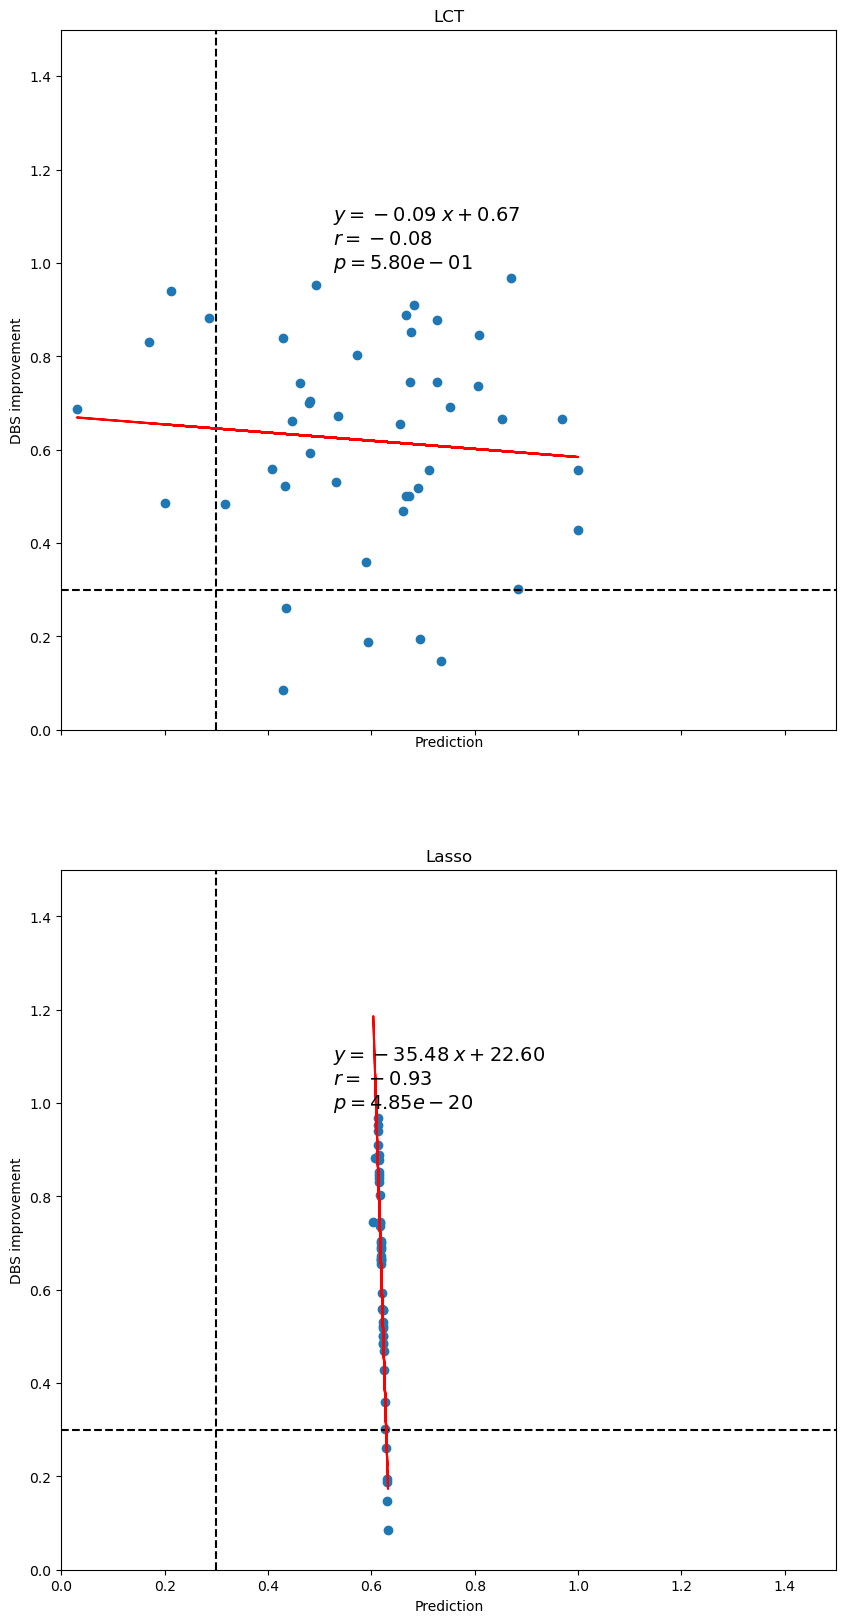

In [34]:
util.eval_prediction(np.vstack((np.squeeze(pre_imp),
                               results_ls.T,
                               )),
                               np.squeeze(per_change),
                               ['LCT',
                                'Lasso',
                                ],(20,10))
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')